In [84]:
# aqui vamos treinar os dados de faturamento do RJ com svm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('..')
from Scripts.utils import (train_model_with_grid_search, load_and_predict, run_rfe, run_lasso, scale_data)

# show all columns 
pd.set_option('display.max_columns', None)
# show entire rows
pd.set_option('display.max_rows', None)
# show all values in a cell
pd.set_option('display.max_colwidth', None)

In [85]:
# carregando os dados
clean_data_rj = pd.read_excel('../Data/clean_data_rj.xlsx')
clean_data_sp = pd.read_excel('../Data/clean_data_sp.xlsx')

In [86]:
clean_data_rj.head()

,nome,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial,popDe25a49,domiciliosA,domiciliosB,popAte14,domicilios,propDomiciliosCriancas,propDomiciliosIdosos,rendaTotal,rendaMediaPop,propDomiciliosA,propDomiciliosB,propDomiciliosC,propDomiciliosD,propDomiciliosE
0,Abolição,11676,1027,483,688,800,1675,2300,1784,2919,0,145,715,1242,1093,758,92,304,2501,932515,Médio,3975,145,1957,1510,4349,0.347206,0.671189,10876849,931.556098,0.033341,0.449989,0.425615,0.021154,0.069901
1,Acari,27564,5131,2188,2697,2630,4810,5308,2403,2397,0,0,82,506,2040,2490,827,2506,931,588833,Baixo,10118,0,588,7319,8451,0.866051,0.283635,7867881,285.440466,0.000000,0.069578,0.536031,0.097858,0.296533
2,Água Santa,9003,883,399,597,762,1755,2076,1112,1419,0,96,404,652,644,522,77,254,2391,874200,Baixo,3831,96,1056,1282,2649,0.483956,0.535674,6333759,703.516495,0.036240,0.398641,0.440166,0.029068,0.095885
3,Alto Da Boa Vista,9606,1072,538,660,685,1317,2007,1341,1986,114,178,393,517,945,584,137,286,3727,912226,Médio,3324,292,910,1610,3154,0.510463,0.629677,11754958,1223.709973,0.092581,0.288523,0.484781,0.043437,0.090679
4,Anchieta,57222,7677,3774,4892,4600,8660,12272,7157,8190,0,0,1089,2821,5110,5422,1073,3261,1380,553020,Médio,20932,0,3910,11451,18776,0.609874,0.436195,25910880,452.813254,0.000000,0.208245,0.560929,0.057147,0.173679


In [87]:
clean_data_rj.corr()['faturamento'].abs().sort_values(ascending=False)

/tmp/ipykernel_1146/2389500722.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  clean_data_rj.corr()['faturamento'].abs().sort_values(ascending=False)


faturamento               1.000000
domiciliosA2              0.797492
domiciliosA               0.791605
propDomiciliosC           0.783892
domiciliosA1              0.756939
rendaMediaPop             0.749079
rendaMedia                0.723298
propDomiciliosA           0.723268
rendaTotal                0.710567
domiciliosB1              0.692057
propDomiciliosCriancas    0.688521
propDomiciliosD           0.627032
propDomiciliosB           0.607609
propDomiciliosIdosos      0.603343
propDomiciliosE           0.528512
domiciliosD               0.503628
domiciliosC2              0.468719
domiciliosB               0.464489
domiciliosE               0.390075
popDe10a14                0.358767
popAte14                  0.352955
popAte9                   0.349904
popMaisDe60               0.318009
popDe15a19                0.307270
domiciliosC1              0.291705
popDe20a24                0.228783
popDe25a34                0.130842
domiciliosB2              0.117434
popDe25a49          

In [88]:
# drop columns 
clean_data_rj.drop(columns=['nome','potencial'], inplace=True)
clean_data_sp.drop(columns=['nome','potencial','faturamento'], inplace=True)

X_sp = clean_data_sp.copy()

## Feature Selection

In [89]:
# separando os dados em treino e teste
X = clean_data_rj.drop('faturamento', axis=1)
y = clean_data_rj['faturamento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lasso_selector, lasso_selected_features = run_lasso(X_test=X_test, X_train=X_train, y_train=y_train)

X_train = X_train[lasso_selected_features]
X_test = X_test[lasso_selected_features]

X_sp = X_sp[lasso_selected_features]

X_train, X_test, scaler = scale_data(X_train, X_test)

                   feature           coef
11            domiciliosB1  172263.990570
19             domiciliosA   79003.969040
26           rendaMediaPop   60301.708764
24    propDomiciliosIdosos   41689.344658
9             domiciliosA1   37946.318155
0                população      -0.000000
1                  popAte9      -0.000000
30         propDomiciliosD      -0.000000
28         propDomiciliosB       0.000000
27         propDomiciliosA       0.000000
25              rendaTotal       0.000000
22              domicilios      -0.000000
21                popAte14      -0.000000
20             domiciliosB       0.000000
18              popDe25a49      -0.000000
17              rendaMedia       0.000000
16             domiciliosE      -0.000000
13            domiciliosC1      -0.000000
12            domiciliosB2      -0.000000
10            domiciliosA2       0.000000
8              popMaisDe60       0.000000
7               popDe50a59      -0.000000
6               popDe35a49      -0

MAE: 51878.464036046425
MSE: 5683051208.300586
RMSE: 75386.01467315132
R2: 0.9299886302101403


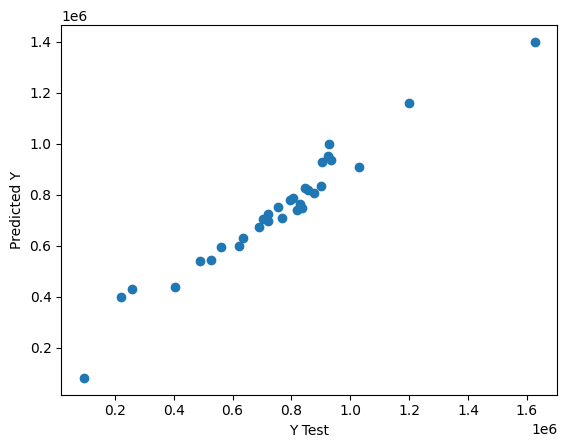

In [90]:
# regressão linear
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)

# avaliando o modelo
predictions = lm.predict(X_test)

# plotando os resultados
plt.scatter(y_test, predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

# avaliando o modelo
print('MAE:', mean_absolute_error(y_test, predictions))
print('MSE:', mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))
print('R2:', r2_score(y_test, predictions))

In [91]:
lm.predict(scaler.transform(X_sp))

array([ 497091.24742592, 1332529.31085117,  188740.10459926,
       1181028.27245999,  784494.24291593, 1203730.95395771,
        799299.05572576, 1463883.24392207, 1260042.79706592,
       1171534.86125081, 1397401.19921755, 1314015.15857168,
        643462.09607739,  971808.51152562,  890381.17154981,
        737115.29161398, 1273528.92666513,  971404.17285923,
       1339818.0767736 , 1120064.03860406, 1191176.11365903,
        973634.36567591, 1388681.99897316,  865803.22153909,
       1293409.78405177,  670322.26723854, 1343720.1795679 ,
        900044.6741396 ,  706158.13852931,  767699.700389  ,
       1502575.22072454, 1251429.36497728,  927219.92569571,
        992955.92294271, 1332698.20410896, 1012648.16893958,
        794607.38609117,  901487.59700119,  921975.90737849,
       1004229.6968859 ,  712451.87455058,  822879.99455592,
       1354591.8714371 , 1138683.43671037,  965359.88135338,
        875911.45200029,  938722.29425214,  865640.01735452,
        204041.12007559,

## Hyperparameters tuning

In [92]:
X = clean_data_rj.drop('faturamento', axis=1)
X = X[lasso_selected_features]
y = clean_data_rj['faturamento']

# Definir o modelo
model = SVR()

param_grid = {
    'model__C': [1, 10, 100, 1000, 10000, 12000], 
    'model__gamma': [1, 0.1, 0.01], 
    'model__kernel': ['poly'], 
    'model__epsilon': [0.3, 0.4, 0.5,0.6,0.7], 
    'model__degree': [1, 2], 
    'model__coef0': [0.0, 0.1, 0.2]
    }

# Chamar a função para treinar o modelo com a busca em grade e salvar
train_model_with_grid_search(X, y, model, param_grid, test_size=0.2, random_state=42, scaling_method='standard', save_path='../Models/svr_model_rj.joblib')

Best parameters: {'model__C': 10000, 'model__coef0': 0.0, 'model__degree': 1, 'model__epsilon': 0.7, 'model__gamma': 1, 'model__kernel': 'poly'}
Model trained and saved successfully!
Score on training set: 0.9693375439744729
Score on test set: 0.896530208624226


In [93]:
# linear regression
model = LinearRegression()

param_grid = {}

# Chamar a função para treinar o modelo com a busca em grade e salvar
train_model_with_grid_search(X, y, model, param_grid, test_size=0.2, random_state=42, scaling_method='standard', save_path='../Models/linear_model_rj.joblib')

Best parameters: {}
Model trained and saved successfully!
Score on training set: 0.9769980025554554
Score on test set: 0.9299886302101403


In [94]:
load_and_predict(X_sp,'../Models/svr_model_rj.joblib')

/home/galvsoliveira/.local/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


array([ 496035.57333379, 1315216.233822  ,  232194.53459032,
       1178200.48240366,  777255.17026685, 1187854.06177831,
        767809.06010186, 1427162.02759213, 1256489.05083808,
       1167498.54237327, 1377907.59296275, 1300742.61687762,
        659006.1318417 ,  929722.02690019,  896789.9363296 ,
        680946.88324988, 1271138.35806795, 1001311.95861586,
       1335521.18029373, 1119500.61861079, 1197444.44303629,
        956468.92907986, 1363385.78273987,  876228.16180274,
       1251434.01819296,  679544.60289968, 1340881.70265759,
        910259.06191186,  669943.00707062,  797936.27314921,
       1497325.15943294, 1259659.44291594,  851677.65741012,
        972613.30636492, 1315213.7571214 ,  966241.82723388,
        782074.14970385,  850188.66944976,  925140.57542992,
        995756.01469139,  674477.1474712 ,  830914.99865336,
       1342631.43590504, 1107894.80725643,  908180.74733891,
        893103.68097932,  954562.79445068,  895492.49846876,
        239431.50226049,

In [95]:
load_and_predict(X_sp,'../Models/linear_model_rj.joblib')

/home/galvsoliveira/.local/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


array([ 497091.24742592, 1332529.31085117,  188740.10459926,
       1181028.27245999,  784494.24291593, 1203730.95395771,
        799299.05572576, 1463883.24392207, 1260042.79706592,
       1171534.86125081, 1397401.19921755, 1314015.15857168,
        643462.09607739,  971808.51152562,  890381.17154981,
        737115.29161398, 1273528.92666513,  971404.17285923,
       1339818.0767736 , 1120064.03860406, 1191176.11365903,
        973634.36567591, 1388681.99897316,  865803.22153909,
       1293409.78405177,  670322.26723854, 1343720.1795679 ,
        900044.6741396 ,  706158.13852931,  767699.700389  ,
       1502575.22072454, 1251429.36497728,  927219.92569571,
        992955.92294271, 1332698.20410896, 1012648.16893958,
        794607.38609117,  901487.59700119,  921975.90737849,
       1004229.6968859 ,  712451.87455058,  822879.99455592,
       1354591.8714371 , 1138683.43671037,  965359.88135338,
        875911.45200029,  938722.29425214,  865640.01735452,
        204041.12007559,

## Exportando o melhor modelo

In [96]:
clean_data_sp['faturamento'] = load_and_predict(X_sp,'../Models/linear_model_rj.joblib')

/home/galvsoliveira/.local/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [97]:
clean_data_sp.head()

,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,popDe25a49,domiciliosA,domiciliosB,popAte14,domicilios,propDomiciliosCriancas,propDomiciliosIdosos,rendaTotal,rendaMediaPop,propDomiciliosA,propDomiciliosB,propDomiciliosC,propDomiciliosD,propDomiciliosE,faturamento
0,94034,12668,6853,9836,7487,14535,21549,10598,10508,0,253,2197,4368,6681,7011,2247,5670,1501,36084,253,6565,19521,28427,0.686706,0.369649,42668927,453.760629,0.008900,0.230942,0.481655,0.079045,0.199458,4.970912e+05
1,32791,2297,1017,2096,2197,5341,7281,4917,7645,1413,1734,3704,2351,1946,827,291,1617,5920,12622,3147,6055,3314,13883,0.238709,0.550673,82187360,2506.399927,0.226680,0.436145,0.199741,0.020961,0.116473,1.332529e+06
2,104193,15070,7343,10631,8657,17749,23364,11567,9812,0,0,1423,4875,8595,10082,3111,5776,1284,41113,0,6298,22413,33862,0.661892,0.289764,43478808,417.291066,0.000000,0.185990,0.551562,0.091873,0.170575,1.887401e+05
3,12721,953,343,627,819,2142,2833,1790,3214,624,667,1558,1032,915,361,84,404,6278,4975,1291,2590,1296,5645,0.229584,0.569353,35439310,2785.890260,0.228698,0.458813,0.226041,0.014880,0.071568,1.181028e+06
4,48417,5078,2396,4018,3571,7388,10751,6648,8567,0,303,1794,2986,4489,2836,1104,2553,1905,18139,303,4780,7474,16065,0.465235,0.533271,30603825,632.088419,0.018861,0.297541,0.455960,0.068721,0.158917,7.844942e+05


In [98]:
# export the data   
clean_data_sp.to_excel('../Data/clean_data_sp_w_revenue.xlsx', index=False)

## Comparação entre os modelos com a base inteira para analisar anomalias

In [99]:
# create a column with the predicted values
clean_data_rj['faturamento_pred_linear'] = load_and_predict(X,'../Models/linear_model_rj.joblib')
clean_data_rj['faturamento_pred_svr'] = load_and_predict(X,'../Models/svr_model_rj.joblib')

/home/galvsoliveira/.local/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/galvsoliveira/.local/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [100]:
# show first 10 rows of fatuamento and faturamento_pred
clean_data_rj['erro_percentage_linear'] = (clean_data_rj['faturamento'] - clean_data_rj['faturamento_pred_linear'])*100/clean_data_rj['faturamento']
clean_data_rj['erro_percentage_svr'] = (clean_data_rj['faturamento'] - clean_data_rj['faturamento_pred_svr'])*100/clean_data_rj['faturamento']
# show rows with erro_percentage > 10 or erro_percentage_svr > 10
clean_data_rj[(clean_data_rj['erro_percentage_linear'] > 10) | (clean_data_rj['erro_percentage_svr'] > 10)]

,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,popDe25a49,domiciliosA,domiciliosB,popAte14,domicilios,propDomiciliosCriancas,propDomiciliosIdosos,rendaTotal,rendaMediaPop,propDomiciliosA,propDomiciliosB,propDomiciliosC,propDomiciliosD,propDomiciliosE,faturamento_pred_linear,faturamento_pred_svr,erro_percentage_linear,erro_percentage_svr
7,249987,32651,15949,20926,20146,37750,53090,31246,38229,0,496,5246,13274,24363,22447,4564,11109,1550,35465,90840,496,18520,48600,81499,0.596326,0.469073,126323450,505.320077,0.006086,0.227242,0.574363,0.056001,0.136308,-2.821810e+04,2.253386e+04,179.566050,36.461702
14,85229,6278,2608,4410,5911,14697,18262,12026,21037,3669,5165,11669,6106,5289,3009,371,1853,8316,2211985,32959,8834,17775,8886,37131,0.239315,0.566562,308781396,3622.961621,0.237914,0.478711,0.223479,0.009992,0.049904,1.995332e+06,1.882384e+06,9.794521,14.900704
47,51456,2612,1241,2044,3049,8071,9582,7426,17431,3253,3648,7334,4041,3677,1434,184,986,10619,1981817,17653,6901,11375,3853,24557,0.156900,0.709818,260770783,5067.840155,0.281020,0.463208,0.208128,0.007493,0.040151,1.860457e+06,1.781889e+06,6.123687,10.088132
56,173,33,13,22,17,28,38,10,12,0,0,0,0,5,17,8,16,654,835491,66,0,0,46,46,1.000000,0.260870,30084,173.895954,0.000000,0.000000,0.478261,0.173913,0.347826,7.476301e+05,7.411169e+05,10.516084,11.295645
65,99102,9633,4743,6564,6855,14400,20477,14384,22046,0,636,4874,8325,10129,6948,1222,3103,2140,1030856,34877,636,13199,14376,35237,0.407980,0.625649,75407180,760.904724,0.018049,0.374578,0.484633,0.034679,0.088061,9.094417e+05,8.400748e+05,11.778009,18.507067
67,161748,24961,10376,13874,16321,32572,35693,14500,13451,422,1244,3405,7984,17034,15909,3178,6837,2160,94671,68265,1666,11389,35337,56013,0.630871,0.240141,120988080,748.003561,0.029743,0.203328,0.588131,0.056737,0.122061,8.227573e+04,2.157727e+05,13.092993,-127.918506
83,133432,22021,9536,12193,12618,24528,29204,11868,11464,0,0,640,4262,12818,15295,2977,8274,1107,24651,53732,0,4902,31557,44266,0.712895,0.258980,49002462,367.246702,0.000000,0.110740,0.635092,0.067253,0.186915,-1.065813e+05,3.622847e+04,532.361081,-46.965507
86,51234,3371,1719,2751,3246,6801,9850,8170,15326,510,1873,5463,5089,3911,1570,131,1356,4671,1626856,16651,2383,10552,5090,19903,0.255740,0.770035,92966913,1814.555042,0.119731,0.530171,0.275386,0.006582,0.068130,1.400018e+06,1.354136e+06,13.943318,16.763620
119,223440,35572,16403,20998,18090,34697,46774,23878,27028,0,0,2057,8310,18161,22160,4572,14833,1188,43346,81471,0,10367,51975,70093,0.741515,0.385602,83270484,372.674919,0.000000,0.147903,0.575250,0.065228,0.211619,-3.073567e+05,-1.673870e+05,809.077354,486.164715
143,13158,1907,904,1139,1165,2245,2948,1417,1433,18,47,124,367,1386,1647,149,827,1495,700834,5193,65,491,2811,4565,0.615772,0.313910,6824675,518.671151,0.014239,0.107558,0.664403,0.032640,0.181161,6.234691e+05,6.559621e+05,11.038971,6.402641


In [101]:
len(clean_data_rj[(clean_data_rj['erro_percentage_linear'] > 10)])/len(clean_data_rj)

0.05263157894736842

In [102]:
len(clean_data_rj[(clean_data_rj['erro_percentage_svr'] > 10)])/len(clean_data_rj)

0.05263157894736842